# 1) Convert From Cartesian Mesh to Polar Mesh
## Shift Instantaneous flow by CM
## Do so for all 20 instantaneous time steps
## Interpolate velocity onto uniform polar mesh (mapped to cartesian)
## Then, using all shifted instantaneous polar meshes, find avg flow field
## Visualize 20 instantaneous swimmer frame flows
## Visualize swimmer frame avg flow field

# 2) Plot Streamlines (inst and avg)

# 3) Using swimmer frame flows, calculate \hat{U}
## \hat{U} = (1/PERIOD)*INTEGRAL_0^T(u - u_avg)e^(iwt)dt
## Use trapezoidal rule
## For every Theta, find \hat{U} vs r

### Imports and Constants

In [1]:
import os,sys
import numpy as np
#import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
import pathlib
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy import interpolate

mpl.rcParams['axes.linewidth'] = 1.5 #set the value globally

#CONSTANTS
dt = 1.0e-3
maxTime = 1000.0
Ntime = int(maxTime/dt)
PERIOD = 0.1
Re = 70.0
RSMALL = 0.15
maxR = 4.0/RSMALL

csfont = {'fontname':'Times New Roman'}
FIGNUM = 0


### 1) Create Cartesian Mesh for velocity field

In [2]:
#Create coordinate field for v(t)
# coordinates of grid endpoints for sphere-centric grid
# and number of points in grid
ax = -maxR
bx =  maxR
ay = -maxR
by =  maxR
m  = 512
# construct sphere meshgrid
sph_x = np.linspace(ax,bx,m)
sph_y = np.linspace(ay,by,m)
mx,my = np.meshgrid(sph_x,sph_y,indexing='xy')

### 2) Store Position Data and Velocity Fields

In [3]:
# constructs a filepath for the pos data of Re = $Re
def pname(Re):
    return "../VelocityFields/Re{:.1f}/pd.txt".format(Re)

# constructs a filename for the ith frame of vel field data
def fname(Re,stem,i):
    return "../VelocityFields/Re{:.1f}/{:s}/res_{:s}_t{:d}.txt".format(Re,stem,stem,i)

#Store and Calculate Vel Field
def getVelField(idxTime):
    arrayUx = np.loadtxt(fname(Re,'Ux',idxTime),skiprows=1)
    arrayUy = np.loadtxt(fname(Re,'Uy',idxTime),skiprows=1)
    flipUx = np.flip(arrayUx,0)
    flipUy = np.flip(arrayUy,0)
    Ux = flipUx.copy()
    Uy = flipUy.copy()
    return Ux,Uy

# pull in timestep information and get which timesteps
# correspond to the current period
ts = np.loadtxt(pname(Re),skiprows=1)
use = np.logical_and(ts[:,-1]>=6.62495,ts[:,-1]<6.72505)
    
# pull out sphere positions for these twenty timesteps
xLcs = ts[use,0]
yLcs = ts[use,1]
xScs = ts[use,2]
yScs = ts[use,3]
xCMcs = xLcs*0.8 + xScs*0.2
yCMcs = yLcs*0.8 + yScs*0.2
    
# slice again to get N many values
nsteps = 20
slice_amt = len(xCMcs)//nsteps
xLcs = xLcs[::slice_amt]/RSMALL
yLcs = yLcs[::slice_amt]/RSMALL
xScs = xScs[::slice_amt]/RSMALL
yScs = yScs[::slice_amt]/RSMALL
xCMcs = xCMcs[::slice_amt]/RSMALL
yCMcs = yCMcs[::slice_amt]/RSMALL

#Assign Cartesian mesh shift values
#For all 20 timesteps
#Currently Large sphere
xShift, yShift = np.zeros(20), np.zeros(20)
for idx in range(20):
    xShift[idx], yShift[idx] = xCMcs[idx], yCMcs[idx]
    print('yShift[%i] = %.3f'%(idx,yShift[idx]))

# get sphere-centric fields
nTime = 20    
nDim = 2
nX = m
nY = m
#Create an array for files Ux, Uy
#For all 20 timesteps
dataU = np.zeros((nTime,nDim,nY,nX))
for idxTime in range(nTime):
    dataU[idxTime,0],dataU[idxTime,1] = getVelField(idxTime)
    print(dataU[idxTime,0].shape)
print('Positions and Velocity fields stored')
    

yShift[0] = 6.579
yShift[1] = 6.596
yShift[2] = 6.609
yShift[3] = 6.619
yShift[4] = 6.627
yShift[5] = 6.634
yShift[6] = 6.638
yShift[7] = 6.642
yShift[8] = 6.646
yShift[9] = 6.650
yShift[10] = 6.654
yShift[11] = 6.659
yShift[12] = 6.665
yShift[13] = 6.674
yShift[14] = 6.686
yShift[15] = 6.701
yShift[16] = 6.719
yShift[17] = 6.738
yShift[18] = 6.759
yShift[19] = 6.779
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
Positions and Velocity fields stored


### 3) Calculate new cartesian mesh and interpolate onto a polar mesh centered around (xShift, yShift)

In [9]:
def InterpolateToNewCoordinateSystem(mx,my,arrayUx,arrayUy):
    #Create a uniform polar mesh for the interpolated velocity vectors!
    r = np.linspace(0.0,maxR,512)
    t = np.linspace(0.0,2.0*np.pi-np.pi/256.0,512)
    mr, mt = np.meshgrid(r,t)

    #Convert uniform polar mesh to cartesian coordinate system
    mx_new = mr*np.cos(mt)
    my_new = mr*np.sin(mt)

    #print('mx_new = ',mx_new)
    #print('my_new = ',my_new)

    #Interpolate Ux and Uy from original cartesian coordainates to new ones
    #Griddata
    arrayUx_new=interpolate.griddata((mx.flatten(),my.flatten()),arrayUx.flatten() , (mx_new,my_new),method='cubic')
    arrayUy_new=interpolate.griddata((mx.flatten(),my.flatten()),arrayUy.flatten() , (mx_new,my_new),method='cubic')

    #Convert Interpolated Ux And Uy to Polar Coordinates
    arrayUr = arrayUx_new*np.cos(mt) + arrayUy_new*np.sin(mt)
    arrayUt = -1.0*arrayUx_new*np.sin(mt) + arrayUy_new*np.cos(mt)

    print('Coordinate Transformation Complete!')
    return (mx_new,my_new,arrayUx_new,arrayUy_new,arrayUr,arrayUt)

#Calculate in Swimmer's frame
#Shift instantaneous flow
#Find the instantaneous interpolations
#Then average flow field on polar grid
newMesh = np.zeros((nTime,nDim,nY,nX))
newU_cart = np.zeros((nTime,nDim,nY,nX))
newU_polar = np.zeros((nTime,nDim,nY,nX))
#Loop over all timesteps and interpolate onto polar mesh
for idxTime in range(nTime):
    #Interpolate for instantaneous data
    print('idxTime = ',idxTime)
    mx_shifted, my_shifted = mx.copy() - xShift[idxTime], my.copy() - yShift[idxTime]
    newMesh[idxTime,0],newMesh[idxTime,1],newU_cart[idxTime,0],newU_cart[idxTime,1],newU_polar[idxTime,0],newU_polar[idxTime,1] = InterpolateToNewCoordinateSystem(mx_shifted,my_shifted,dataU[idxTime,0],dataU[idxTime,1])
#Now average Ur and Ut for instantaneous flows
#And new U_cart
CM_avgU_cart = np.zeros((nDim,nY,nX))
CM_avgU_polar = np.zeros((nDim,nY,nX))
for idxTime in range(nTime):
    CM_avgU_cart += newU_cart[idxTime]/nTime
    CM_avgU_polar += newU_polar[idxTime]/nTime
print('Interpolation and averaging in swimmer frame is complete')

idxTime =  0
Coordinate Transformation Complete!
idxTime =  1
Coordinate Transformation Complete!
idxTime =  2
Coordinate Transformation Complete!
idxTime =  3
Coordinate Transformation Complete!
idxTime =  4
Coordinate Transformation Complete!
idxTime =  5
Coordinate Transformation Complete!
idxTime =  6
Coordinate Transformation Complete!
idxTime =  7
Coordinate Transformation Complete!
idxTime =  8
Coordinate Transformation Complete!
idxTime =  9
Coordinate Transformation Complete!
idxTime =  10
Coordinate Transformation Complete!
idxTime =  11
Coordinate Transformation Complete!
idxTime =  12
Coordinate Transformation Complete!
idxTime =  13
Coordinate Transformation Complete!
idxTime =  14
Coordinate Transformation Complete!
idxTime =  15
Coordinate Transformation Complete!
idxTime =  16
Coordinate Transformation Complete!
idxTime =  17
Coordinate Transformation Complete!
idxTime =  18
Coordinate Transformation Complete!
idxTime =  19
Coordinate Transformation Complete!
Interpolat

### 4) Check if new mesh is calculated correctly
#### Plot shifted and interpolated velocity fields

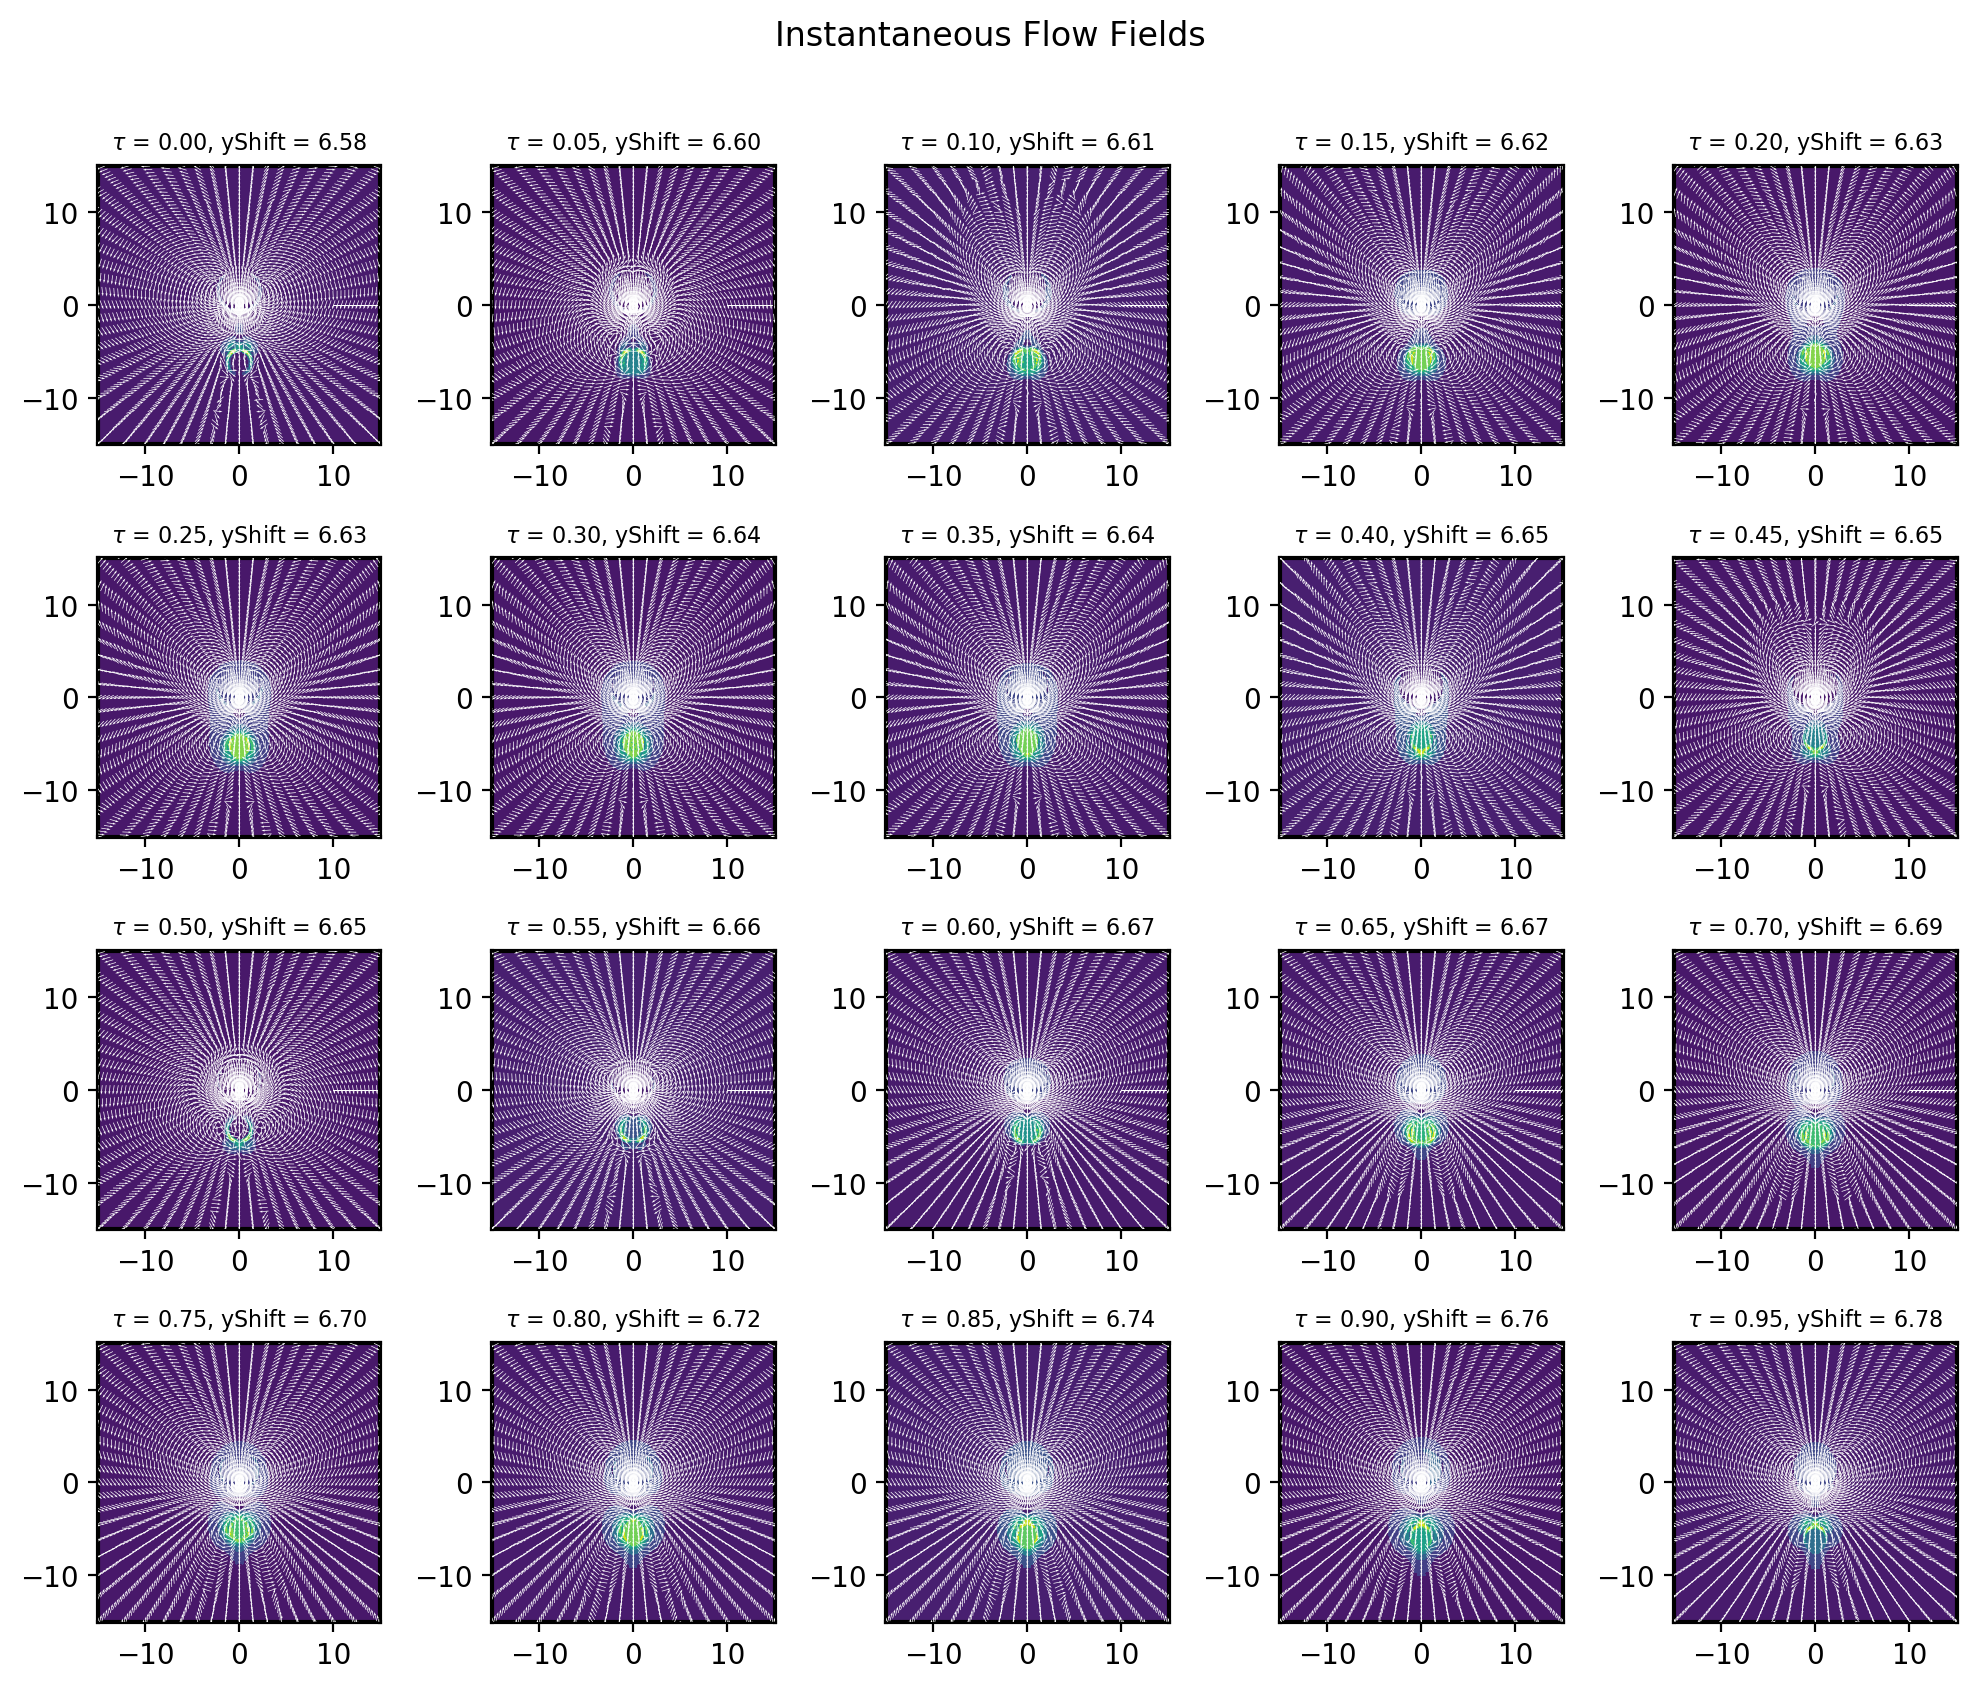

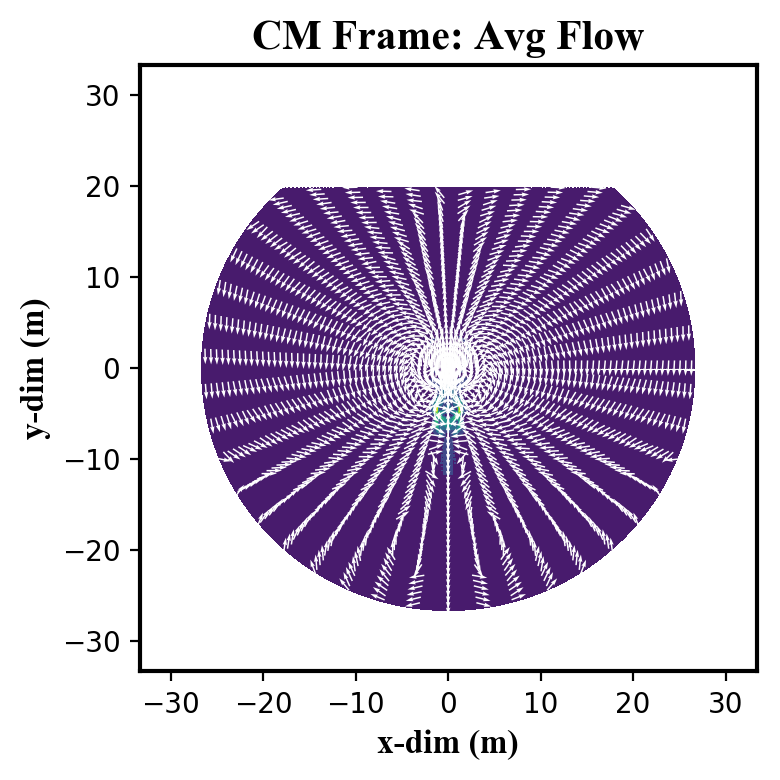

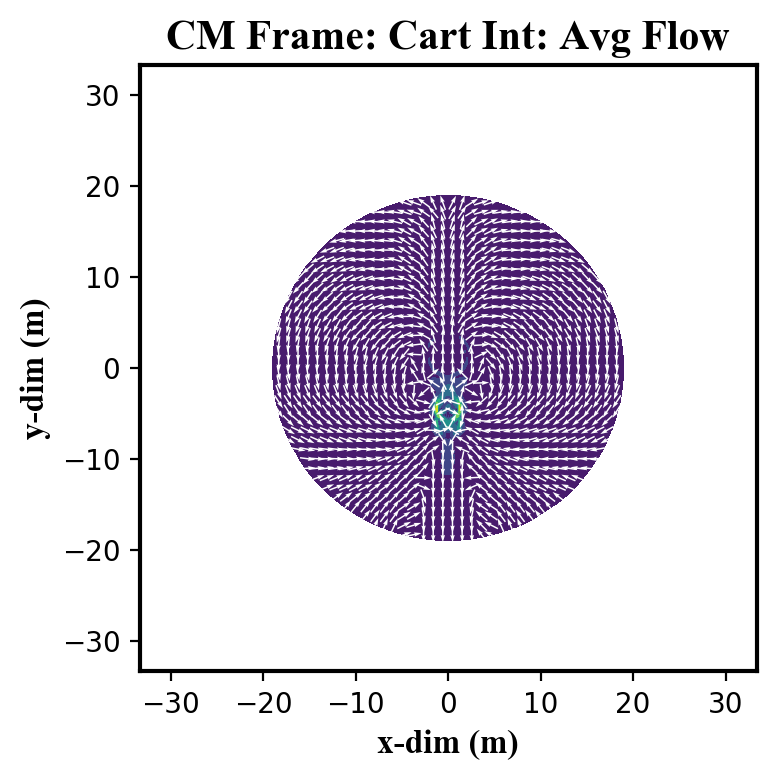

In [12]:
#Plot New mesh and interpolated velocity field Ux and Uy
#Instantaneous Flow
def PlotInstantaneousU(mesh,U,yShift):
    global FIGNUM, PERIOD
    #Here, we will visualize the velocity field on the new coordinate system
    nRows, nCols = 4, 5
    fig, ax = plt.subplots(nrows=nRows, ncols=nCols, num=FIGNUM,figsize=(10,8),dpi=200)
    count = 0
    space = 8 #spacing for quiver plot
    fig.suptitle('Instantaneous Flow Fields',fontsize=12, y=1.05)
    for idxR in range(nRows):
        for idxC in range(nCols):
            ax[idxR,idxC].set_title(r'$\tau$ = %.2f, yShift = %.2f'%(0.5*count*PERIOD,yShift[count]),fontsize=8)
            mx, my = mesh[count,0], mesh[count,1]
            Ux, Uy = U[count,0].copy(), U[count,1].copy()
            normUx,normUy = Ux/np.hypot(Ux,Uy),Uy/np.hypot(Ux,Uy)
            magU = np.hypot(Ux,Uy)
            ax[idxR,idxC].quiver(mx[::space,::space],my[::space,::space],
              normUx[::space,::space],normUy[::space,::space],
              color='white',pivot='mid',scale=30,zorder=5)
            ax[idxR,idxC].contourf(mx,my,magU,cmap='viridis')
            #print('RSMALL = ',RSMALL)
            ax[idxR,idxC].axis([-15,15,-15,15])
            #ax.axis([-4,4,-4,4])
            count += 1
    fig.tight_layout()
    plt.show()
    fig.clf()
    FIGNUM += 1
    plt.close()
    return

#Plot New Ux and Uy
def PlotAveragedU(mx,my,Ux,Uy,title,spacing):
    #Here, we will visualize the velocity field on the new coordinate system
    fig = plt.figure(figsize=(4,4),dpi=200)
    ax = fig.add_subplot(111)
    #We will specify the time in the x-label
    ax.set_title(title,fontsize=15,**csfont)
    ax.set_xlabel('x-dim (m)',fontsize=12,**csfont)
    ax.set_ylabel('y-dim (m)',fontsize=12,**csfont)
    #Now that we have the figure all labeled, let's add the force field
    space = spacing
    normUx,normUy = Ux/np.hypot(Ux,Uy),Uy/np.hypot(Ux,Uy)
    magU = np.hypot(Ux,Uy)
    '''img = ax.imshow(magU,interpolation='none',cmap='viridis',
               extent=[-4,4,-4,4],
               #vmin = 0, vmax = 10,
               origin='lower',aspect='equal')'''
    ax.quiver(mx[::space,::space],my[::space,::space],
              normUx[::space,::space],normUy[::space,::space],
              color='white',pivot='mid',scale=40,zorder=5)
    ax.contourf(mx,my,magU,cmap='viridis')
    #ax.scatter(mx,my,c=magU,cmap='viridis',s=10)
    #ax.axis([-15.0,15.0,-15.0,15.0])
    ax.axis([-5.0/RSMALL,5.0/RSMALL,-5.0/RSMALL,5.0/RSMALL])
    #ax.axis([-4,4,-4,4])
    fig.tight_layout()
    plt.show()
    fig.clf()
    plt.close()
    return

#Instantaneous Plotting
PlotInstantaneousU(newMesh,newU_cart,yShift)

#Check CM frame
r = np.linspace(0.0,maxR,512)
t = np.linspace(0.0,2.0*np.pi-np.pi/256.0,512)
mr, mt = np.meshgrid(r,t)
#Convert uniform polar mesh to cartesian coordinate system
mx_new = mr*np.cos(mt)
my_new = mr*np.sin(mt)
plotTitle = 'CM Frame: Avg Flow'
PlotAveragedU(mx_new,my_new,CM_avgU_cart[0],CM_avgU_cart[1],plotTitle,12)

#Interpolate Ux and Uy from original cartesian coordainates to new ones
#Griddata
mx2_new = mx_new[mr < 19.0]
my2_new = my_new[mr < 19.0]
CM_avgUx = CM_avgU_cart[0].copy()
CM_avgUy = CM_avgU_cart[1].copy()
CM_avgUx2 = CM_avgUx[mr < 19.0]
CM_avgUy2 = CM_avgUy[mr < 19.0]
U_CM_avgUx_cart=interpolate.griddata((mx2_new.flatten(),my2_new.flatten()),CM_avgUx2.flatten() , (mx,my),method='cubic')
U_CM_avgUy_cart=interpolate.griddata((mx2_new.flatten(),my2_new.flatten()),CM_avgUy2.flatten() , (mx,my),method='cubic')
plotTitle = 'CM Frame: Cart Int: Avg Flow'
PlotAveragedU(mx,my,U_CM_avgUx_cart,U_CM_avgUy_cart,plotTitle,10)


### 5) Plot Streamlines for instantaneous fields

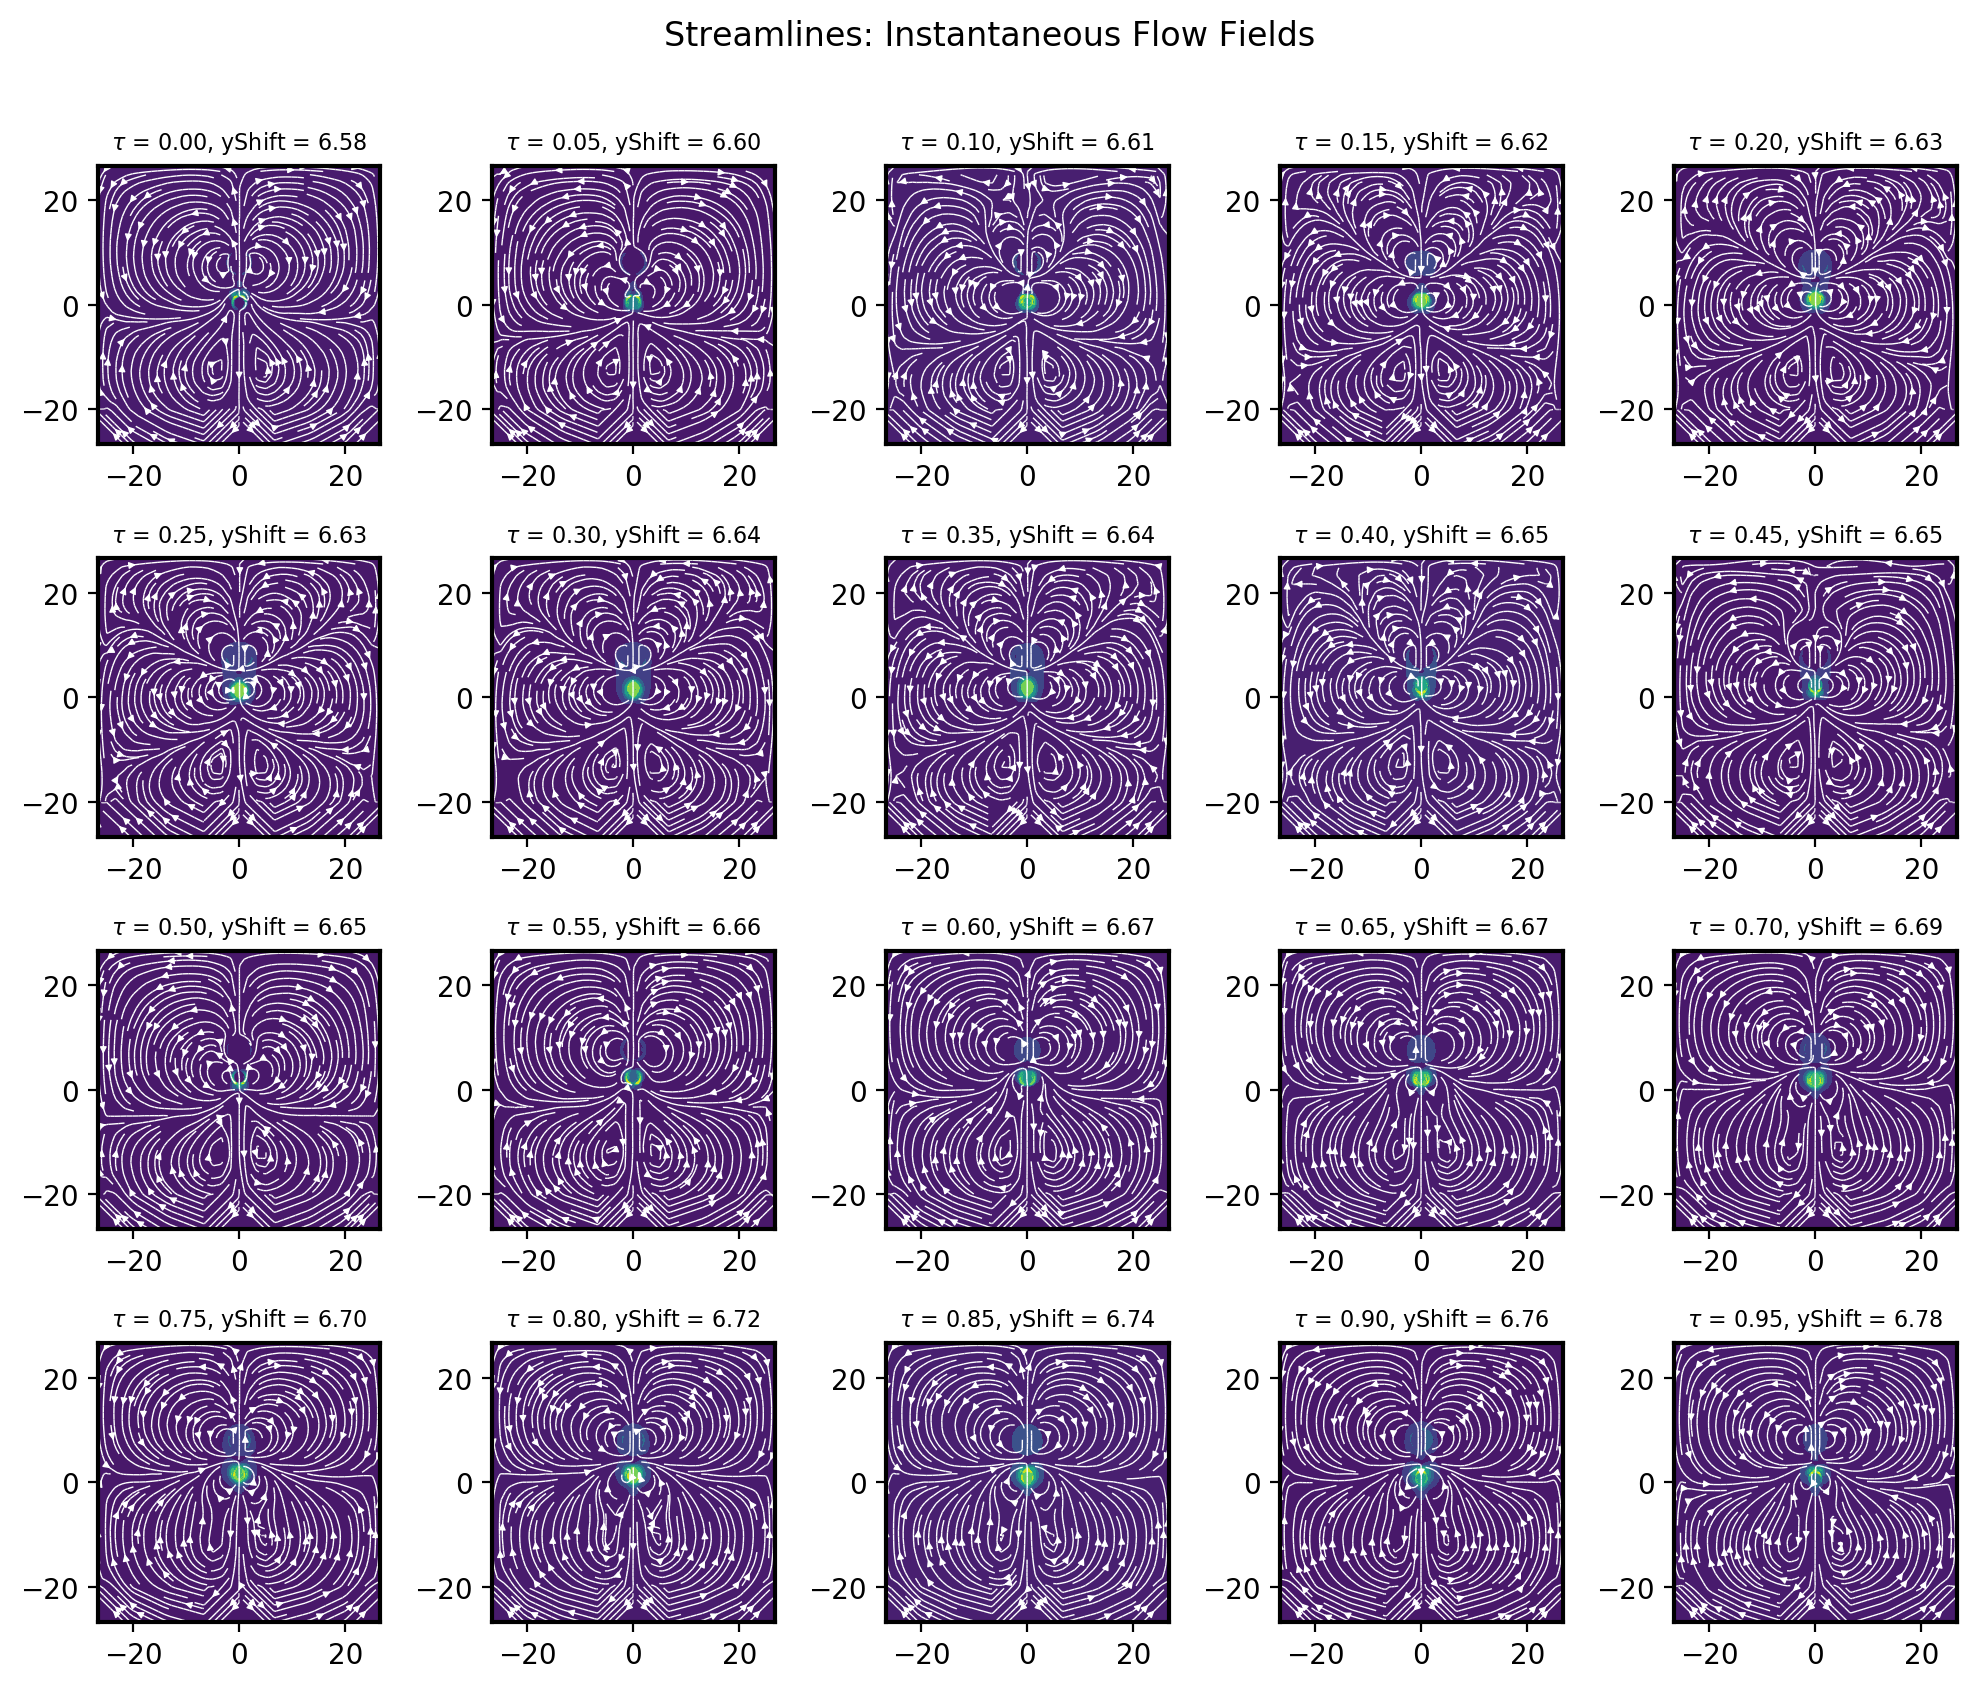

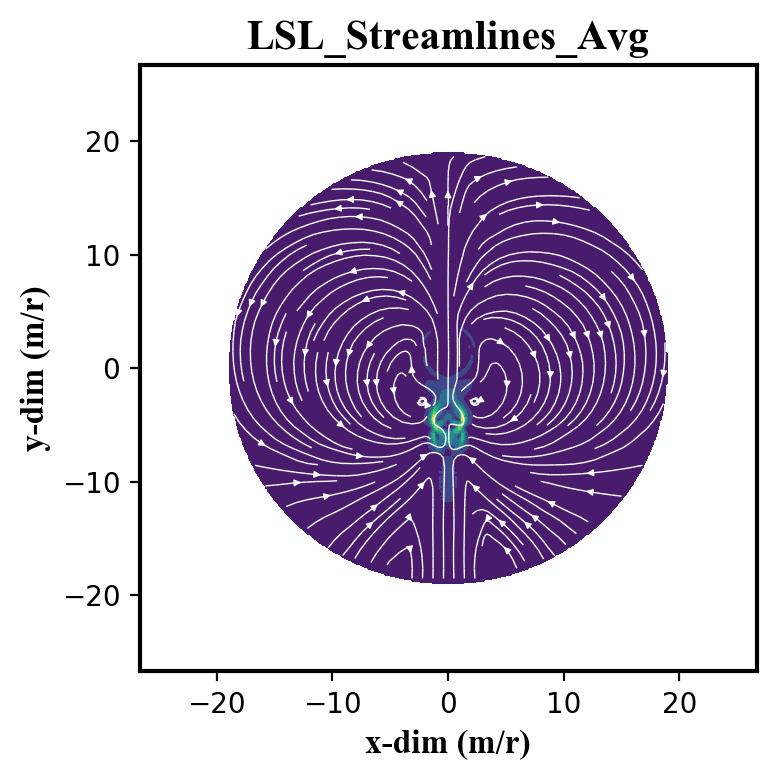

In [6]:
#Plot Streamlines for interpolated velocity fields Ux and Uy
def PlotInstStreamsU(mx,my,U,yShift):
    global FIGNUM, PERIOD
    #Here, we will visualize the velocity field on the new coordinate system
    nRows, nCols = 4, 5
    fig, ax = plt.subplots(nrows=nRows, ncols=nCols, num=FIGNUM,figsize=(10,8),dpi=200)
    count = 0
    space = 8 #spacing for quiver plot
    fig.suptitle('Streamlines: Instantaneous Flow Fields',fontsize=12, y=1.05)
    for idxR in range(nRows):
        for idxC in range(nCols):
            ax[idxR,idxC].set_title(r'$\tau$ = %.2f, yShift = %.2f'%(0.5*count*PERIOD,yShift[count]),fontsize=8)
            Ux, Uy = U[count,0].copy(), U[count,1].copy()
            normUx,normUy = Ux/np.hypot(Ux,Uy),Uy/np.hypot(Ux,Uy)
            magU = np.hypot(Ux,Uy)
            ax[idxR,idxC].contourf(mx,my,magU,cmap='viridis')
            ax[idxR,idxC].streamplot(mx,my,Ux,Uy,color='white',linewidth=0.5,arrowsize=0.5,density=1.5)
            ax[idxR,idxC].axis([-4.0/RSMALL,4.0/RSMALL,-4.0/RSMALL,4.0/RSMALL])
            count += 1
    fig.tight_layout()
    plt.show()
    fig.clf()
    FIGNUM += 1
    plt.close()
    return

#Make a StreamLine Plot
def PlotAvgStreamsU(mx,my,Ux,Uy,title):
    #Here, we will visualize the velocity field on the new coordinate system
    fig = plt.figure(figsize=(4,4),dpi=200)
    ax = fig.add_subplot(111)
    #We will specify the time in the x-label
    ax.set_title(title,fontsize=15,**csfont)
    ax.set_xlabel('x-dim (m/r)',fontsize=12,**csfont)
    ax.set_ylabel('y-dim (m/r)',fontsize=12,**csfont)
    #Now that we have the figure all labeled, let's add the force field
    space = 5
    magU = np.hypot(Ux,Uy)
    ax.contourf(mx,my,magU,cmap='viridis')
    ax.streamplot(mx,my,Ux,Uy,color='white',linewidth=0.5,arrowsize=0.5,density=2.0)
    #ax.axis([-2.0,2.0,-3.0,1.0])
    ax.axis([-4.0/RSMALL,4.0/RSMALL,-4.0/RSMALL,4.0/RSMALL])
    fig.tight_layout()
    plt.show()
    fig.savefig(title+'.png')
    fig.clf()
    plt.close()
    return

#Instantaneous Plotting
PlotInstStreamsU(mx,my,dataU,yShift)
#PlotInstStreamsU(mx_new,my_new,newU_cart,yShift)

#Average Plotting
title = 'LSL_Streamlines_Avg'
#PlotAvgStreamsU(avgmx_shifted,avgmy_shifted,avgU[0],avgU[1],title)
PlotAvgStreamsU(mx,my,U_CM_avgUx_cart,U_CM_avgUy_cart,title)


# 6) Using swimmer frame flows, calculate \hat{U}
## \hat{U} = (1/PERIOD)*INTEGRAL_0^T(u - u_avg)e^(iwt)dt
## Use trapezoidal rule
## For every Theta, find \hat{U} vs r

0.005
0.005
min =  4.47166043428e-06
max =  4.56348034729


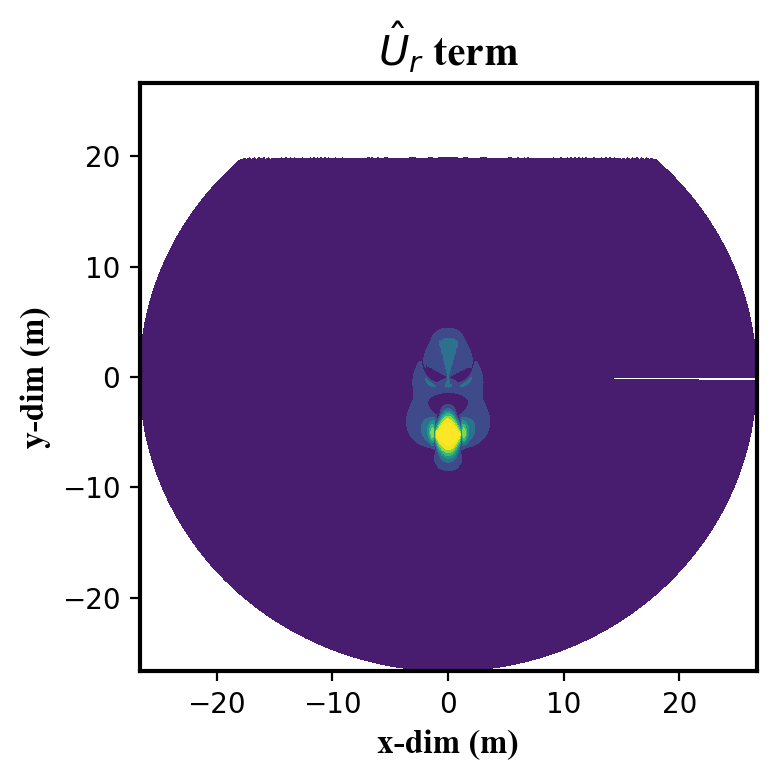

min =  1.01320712871e-05
max =  2.31930910204


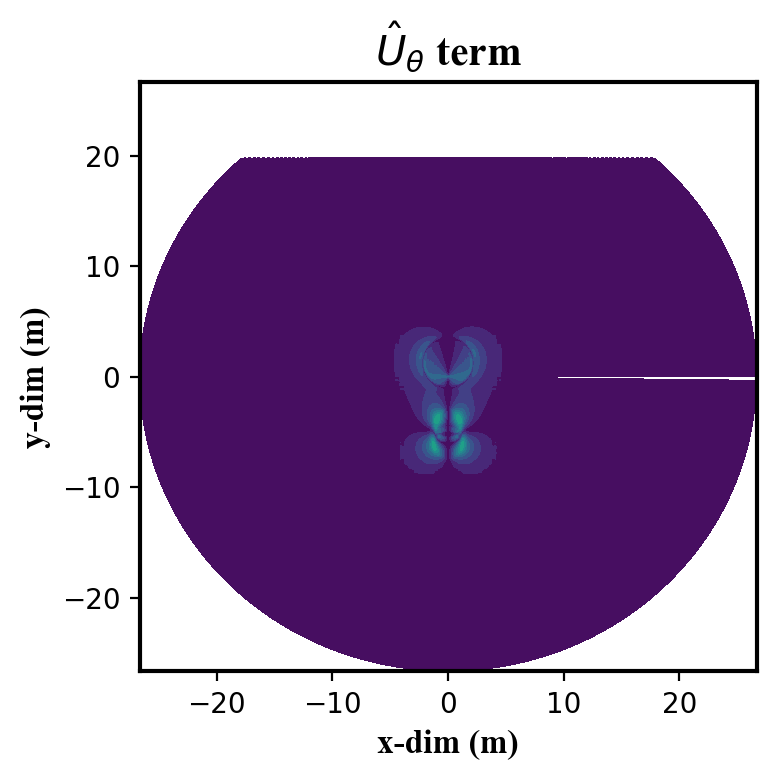

In [7]:
import pandas as pd

#Variables to be used
#Mesh: newMesh (all timesteps have same mesh now)
#Inst: newU_cart, newU_polar
#Avg: CM_avgU_cart, CM_avgU_polar
#Variables to be calculated
#Inst: hatU = 1/PERIOD*INTEGRAL_0_T(U - U_avg)*e^(iwt)dt

#Plot hatU contour
def PlothatU(mx,my,hatU,title):
    #Here, we will visualize the velocity field on the new coordinate system
    fig = plt.figure(figsize=(4,4),dpi=200)
    ax = fig.add_subplot(111)
    #We will specify the time in the x-label
    ax.set_title(title,fontsize=15,**csfont)
    ax.set_xlabel('x-dim (m)',fontsize=12,**csfont)
    ax.set_ylabel('y-dim (m)',fontsize=12,**csfont)
    #Now that we have the figure all labeled, let's add the force field
    space = 10
    ax.contourf(mx,my,hatU,cmap='viridis',vmin=0.0,vmax=4.0)
    #ax.axis([-15.0,15.0,-15.0,15.0])
    ax.axis([-4.0/RSMALL,4.0/RSMALL,-4.0/RSMALL,4.0/RSMALL])
    #ax.axis([-4,4,-4,4])
    fig.tight_layout()
    plt.show()
    fig.clf()
    plt.close()
    return

def Trapezoidal(data, minBound, maxBound, nTime):
    h = (maxBound-minBound)/float(nTime)
    print(h)
    s = 0.5*(data[0] + data[nTime-1])
    for idx in range(1,nTime-1):
        s = s + data[idx]
    return h*s

#Allocate Variables
#0 = xcos, 1 = x(isin), 2 = ycos, 3 = y(isin)
hatU_cart_terms = np.zeros((nTime,4,512,512))
hatU_polar_terms = np.zeros((nTime,4,512,512))

for idxTime in range(nTime):
    #Assign variables
    time = idxTime*PERIOD/nTime
    #print('time = ',time)
    Ux, Uy = newU_cart[idxTime,0], newU_cart[idxTime,1]
    Ur, Ut = newU_polar[idxTime,0], newU_polar[idxTime,1]
    avgUx, avgUy = CM_avgU_cart[0], CM_avgU_cart[1]
    avgUr, avgUt = CM_avgU_polar[0], CM_avgU_polar[1]
    #Calculate hatU
    dictU = {'mx':newMesh[idxTime,0].flatten(),'my':newMesh[idxTime,1].flatten(),'Ux':Ux.flatten(),'Uy':Uy.flatten(),
             'Ur':Ur.flatten(),'Ut':Ut.flatten(),'avgUx':avgUx.flatten(),'avgUy':avgUy.flatten(),
             'avgUr':avgUr.flatten(),'avgUt':avgUt.flatten()}
    data = pd.DataFrame(data=dictU)
    #data = data.sort_values(by=['mx','my'])
    data = data.reset_index(drop=True)
    #Cartesian
    data['hatUx_cos'] = (data['Ux'] - data['avgUx'])*np.cos(2.0*time*np.pi/PERIOD)
    data['hatUy_cos'] = (data['Uy'] - data['avgUy'])*np.cos(2.0*time*np.pi/PERIOD)
    data['hatUx_isin'] = (data['Ux'] - data['avgUx'])*np.sin(2.0*time*np.pi/PERIOD)
    data['hatUy_isin'] = (data['Uy'] - data['avgUy'])*np.sin(2.0*time*np.pi/PERIOD)
    #Polar
    data['hatUr_cos'] = (data['Ur'] - data['avgUr'])*np.cos(2.0*time*np.pi/PERIOD)
    data['hatUt_cos'] = (data['Ut'] - data['avgUt'])*np.cos(2.0*time*np.pi/PERIOD)
    data['hatUr_isin'] = (data['Ur'] - data['avgUr'])*np.sin(2.0*time*np.pi/PERIOD)
    data['hatUt_isin'] = (data['Ut'] - data['avgUt'])*np.sin(2.0*time*np.pi/PERIOD)
    #Extract hatU terms
    #print(data['hatUx_cos'].head())
    #Cartesian
    hatUx_cos = data['hatUx_cos'].values.tolist() 
    #print(hatUx_cos[:5])
    hatUy_cos = data['hatUy_cos'].values.tolist()
    hatUx_isin = data['hatUx_isin'].values.tolist()
    hatUy_isin = data['hatUy_isin'].values.tolist()
    #Polar
    hatUr_cos = data['hatUr_cos'].values.tolist()
    hatUt_cos = data['hatUt_cos'].values.tolist()
    hatUr_isin = data['hatUr_isin'].values.tolist()
    hatUt_isin = data['hatUt_isin'].values.tolist()
    #Convert List to numpy array and reshape to (512,512)
    arr_hatUx_cos = np.array(hatUx_cos).reshape((512,512))
    #print(arr_hatUx_cos[0,:5])
    arr_hatUy_cos = np.array(hatUy_cos).reshape((512,512))
    arr_hatUx_isin = np.array(hatUx_isin).reshape((512,512))
    arr_hatUy_isin = np.array(hatUy_isin).reshape((512,512))
    #Polar
    arr_hatUr_cos = np.array(hatUr_cos).reshape((512,512))
    arr_hatUt_cos = np.array(hatUt_cos).reshape((512,512))
    arr_hatUr_isin = np.array(hatUr_isin).reshape((512,512))
    arr_hatUt_isin = np.array(hatUt_isin).reshape((512,512))
    #Store hatU terms in hatU arrays
    #Cartesian
    hatU_cart_terms[idxTime,0] = arr_hatUx_cos.copy()
    hatU_cart_terms[idxTime,1] = arr_hatUx_isin.copy()
    hatU_cart_terms[idxTime,2] = arr_hatUy_cos.copy()
    hatU_cart_terms[idxTime,3] = arr_hatUy_isin.copy()
    #Polar
    hatU_polar_terms[idxTime,0] = arr_hatUr_cos.copy()
    hatU_polar_terms[idxTime,1] = arr_hatUr_isin.copy()
    hatU_polar_terms[idxTime,2] = arr_hatUt_cos.copy()
    hatU_polar_terms[idxTime,3] = arr_hatUt_isin.copy()
    
#Now that all the hatU terms have been calculated, we can now find the integral using trapezoidal rule
#Allocate Magnitude vectors
hatU_cart = np.zeros((4,512,512))
hatU_polar = np.zeros((4,512,512))
hatUmag = np.zeros((2,512,512)) 
#Calculate
hatU_cart = (1.0/PERIOD)*Trapezoidal(hatU_cart_terms,0,PERIOD,nTime)
hatU_polar = (1.0/PERIOD)*Trapezoidal(hatU_polar_terms,0,PERIOD,nTime)
hatUmag[0] = np.hypot(hatU_polar[0],hatU_polar[1])
hatUmag[1] = np.hypot(hatU_polar[2],hatU_polar[3])
#Plot hatU flow field magnitudes
plotTitle = r'$\hat{U}_r$ term'
print('min = ',np.amin(hatUmag[0][np.isfinite(hatUmag[0])]))
print('max = ',np.amax(hatUmag[0][np.isfinite(hatUmag[0])]))
PlothatU(newMesh[0,0],newMesh[0,1],hatUmag[0],plotTitle)
plotTitle = r'$\hat{U}_{\theta}$ term'
print('min = ',np.amin(hatUmag[1][np.isfinite(hatUmag[1])]))
print('max = ',np.amax(hatUmag[1][np.isfinite(hatUmag[1])]))
PlothatU(newMesh[0,0],newMesh[0,1],hatUmag[1],plotTitle)


/Users/thomas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars


num mt_list =  261632
num set_t =  512


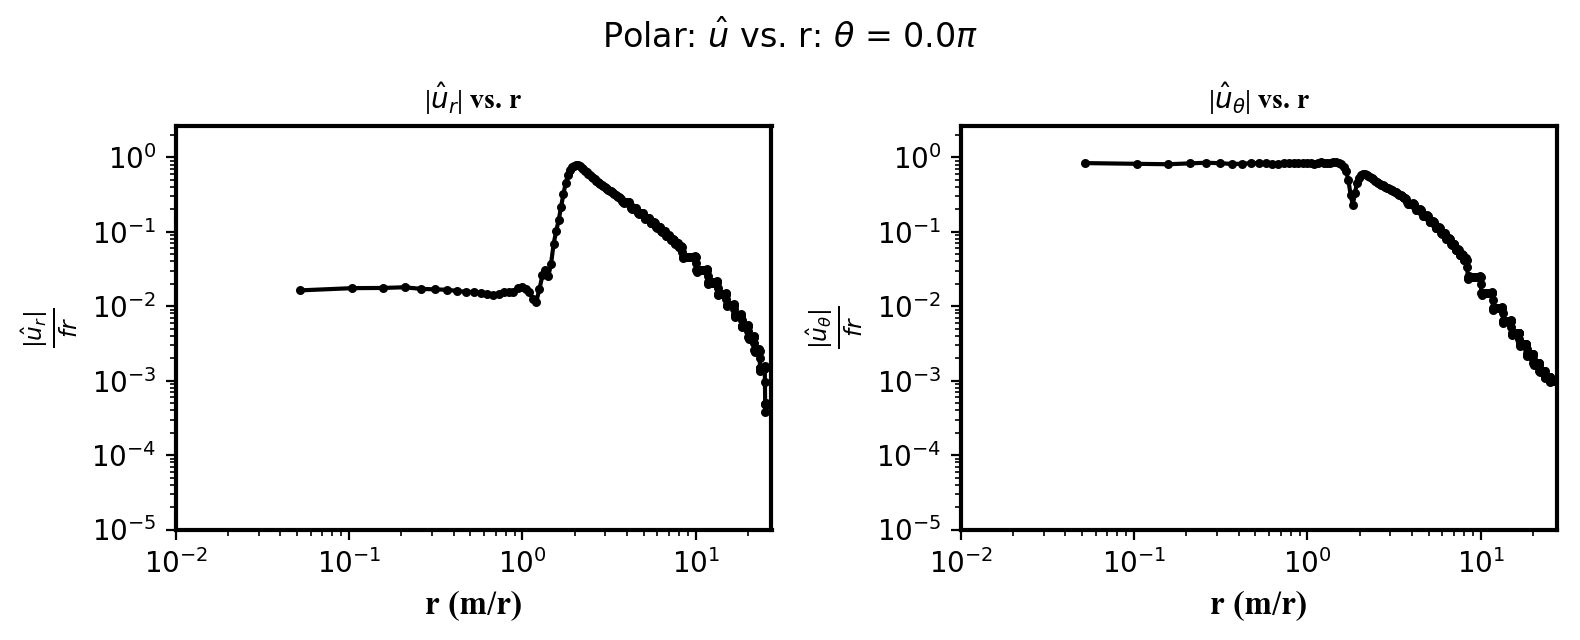

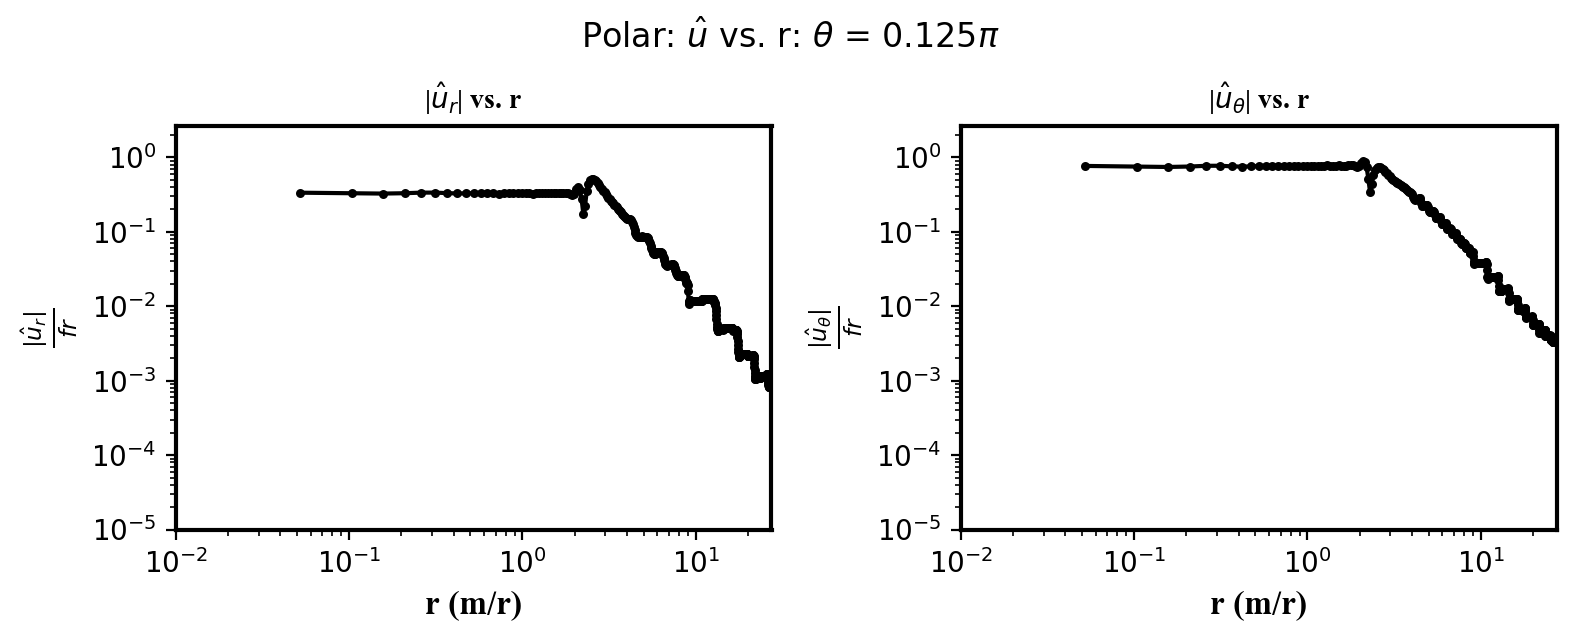

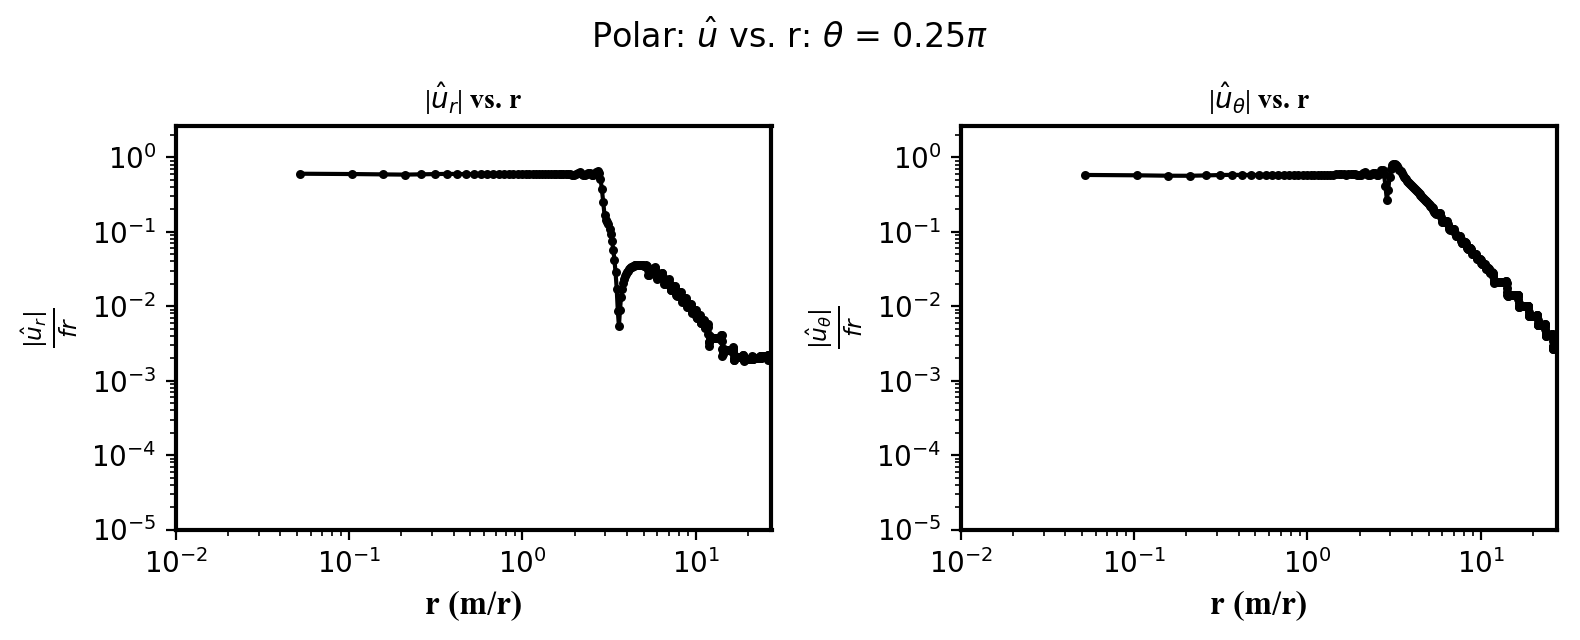

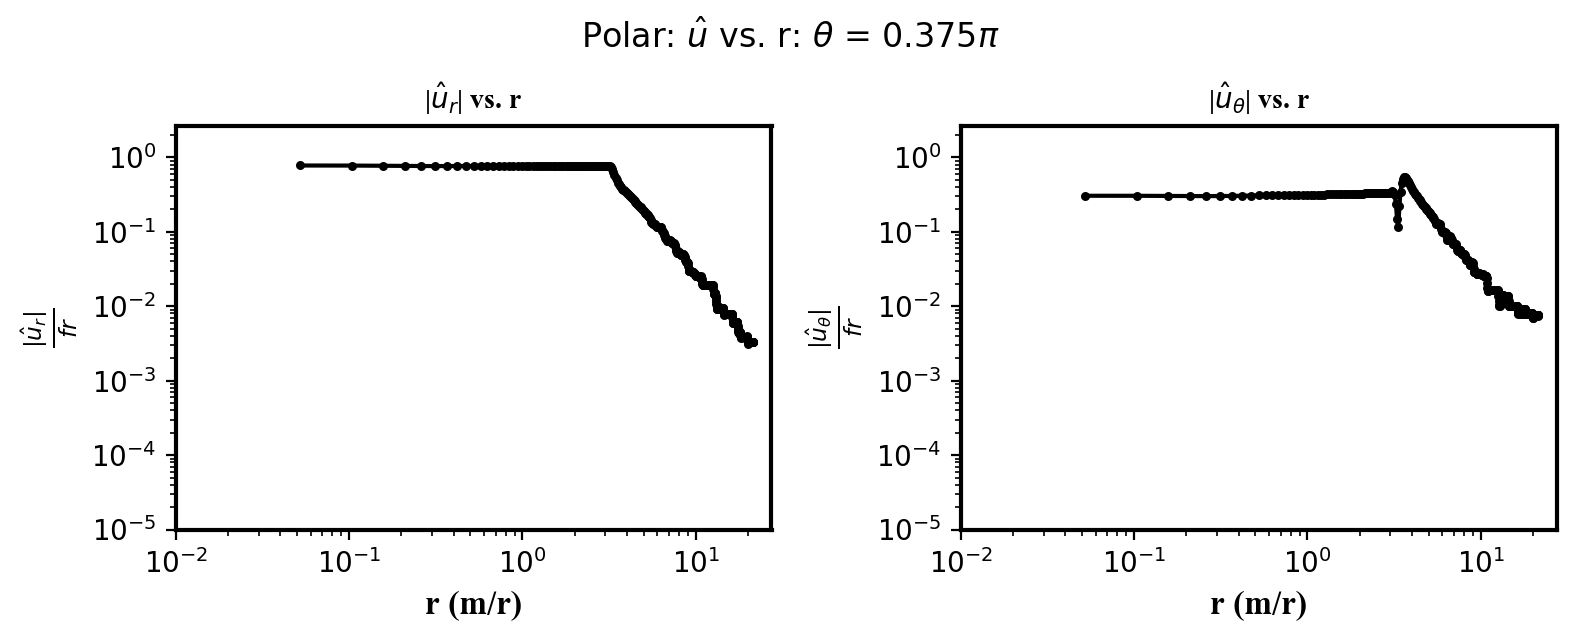

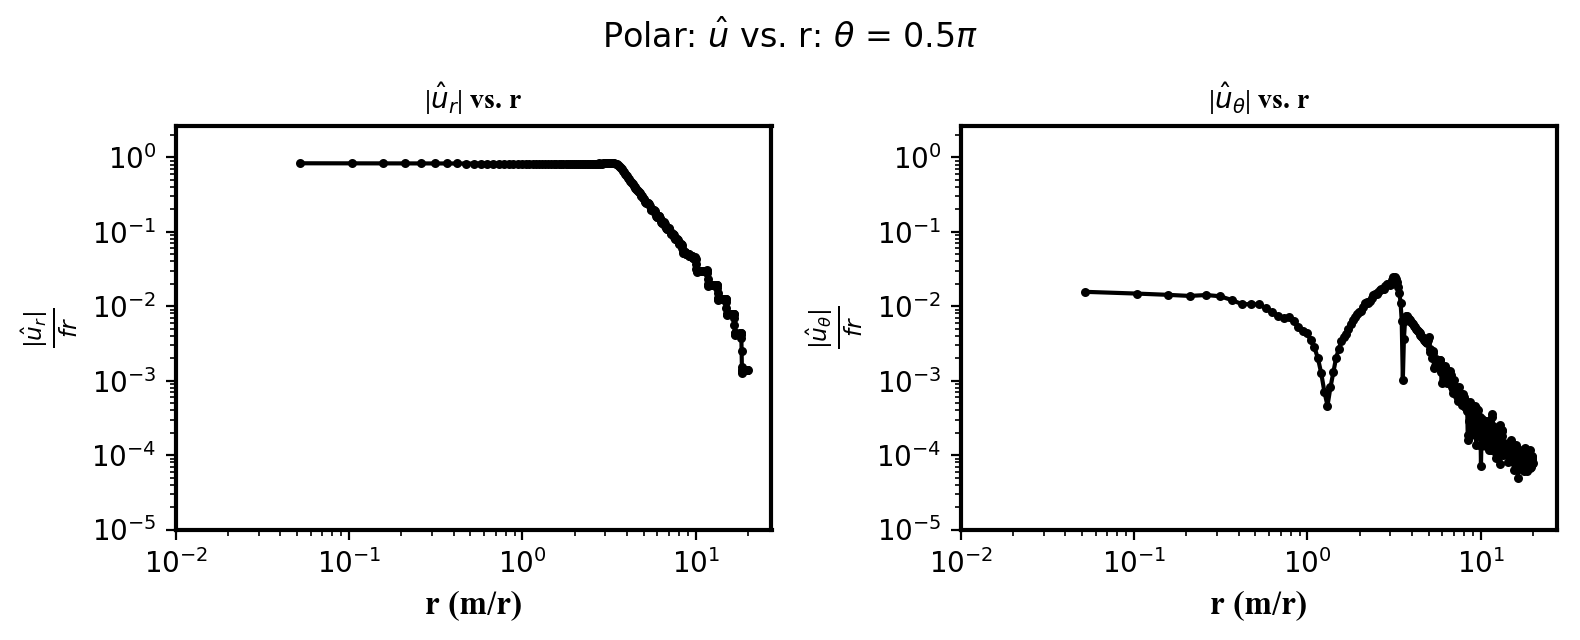

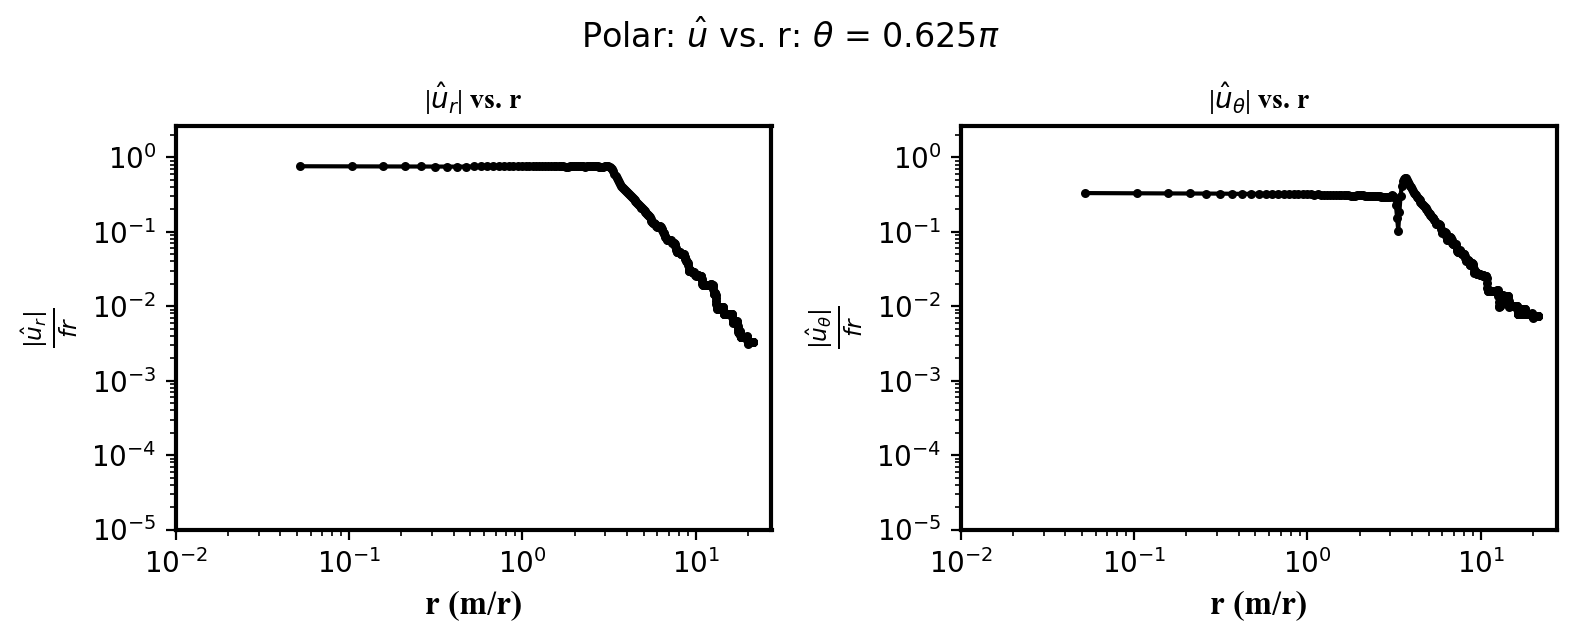

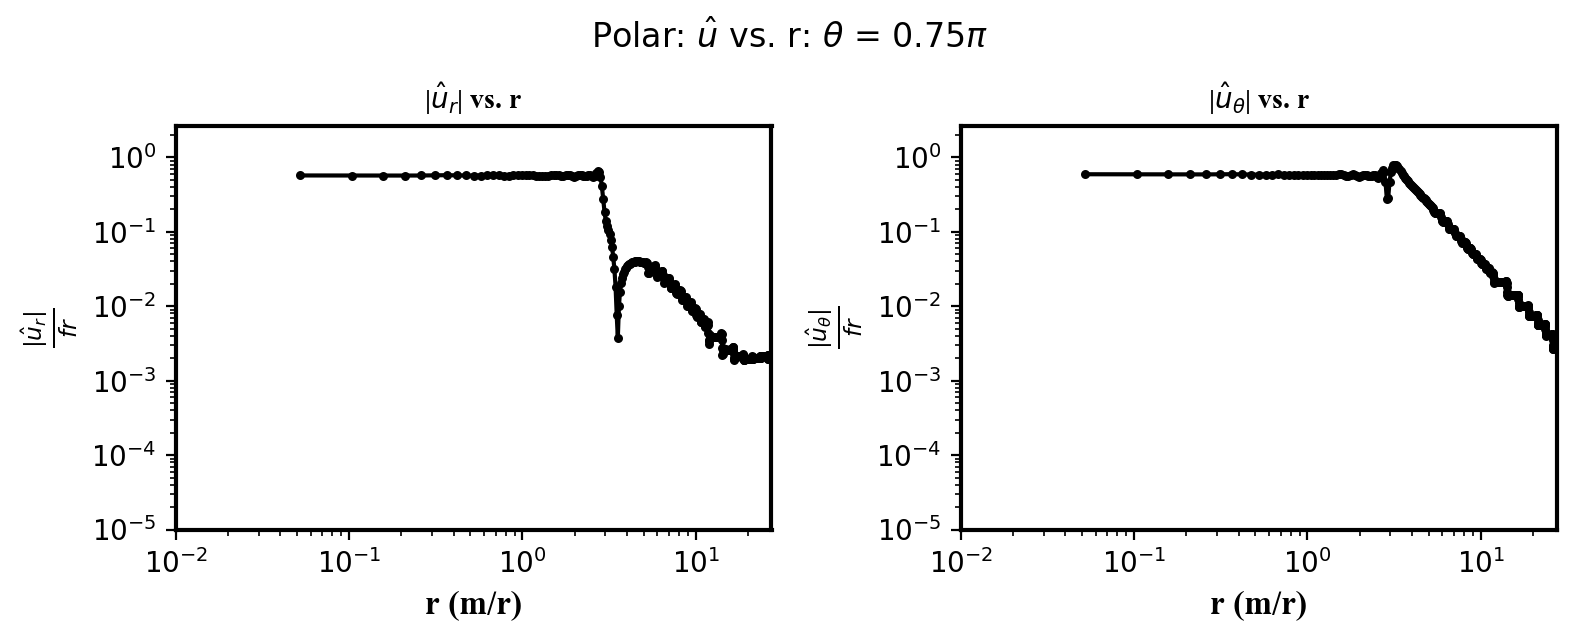

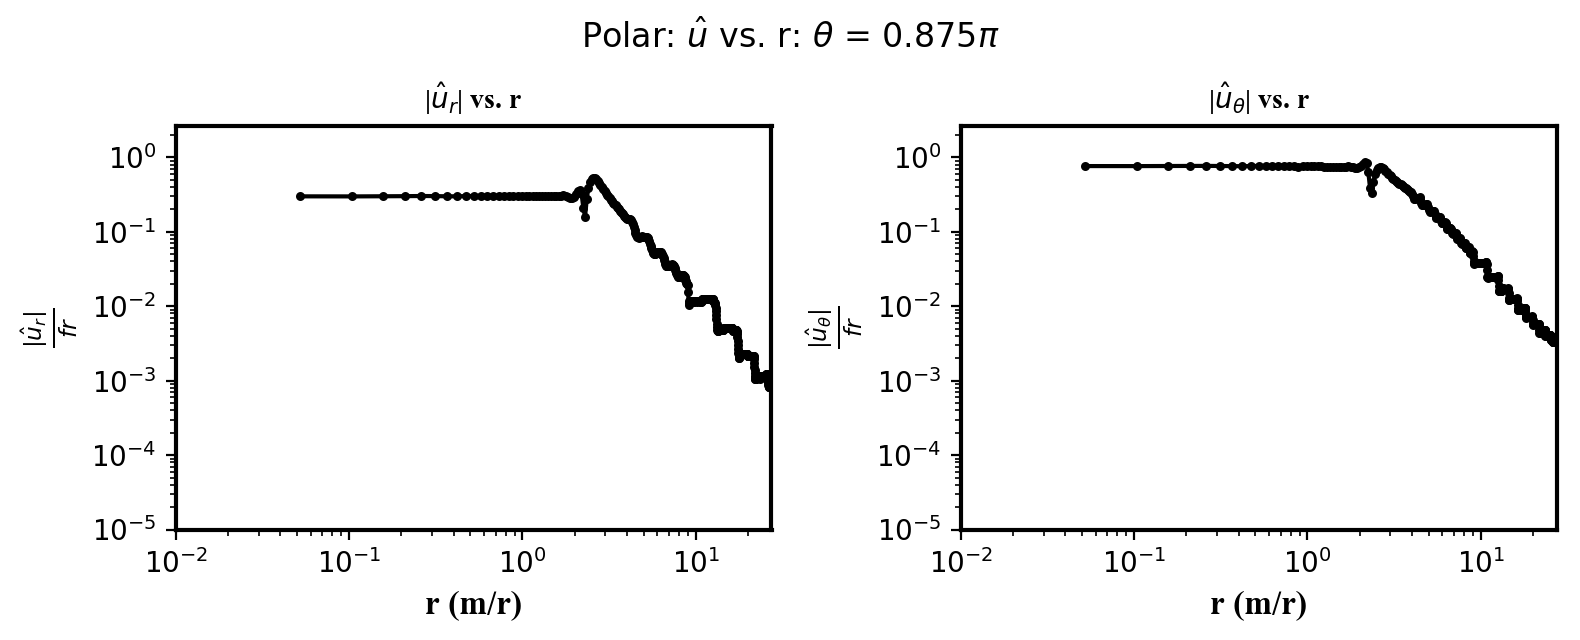

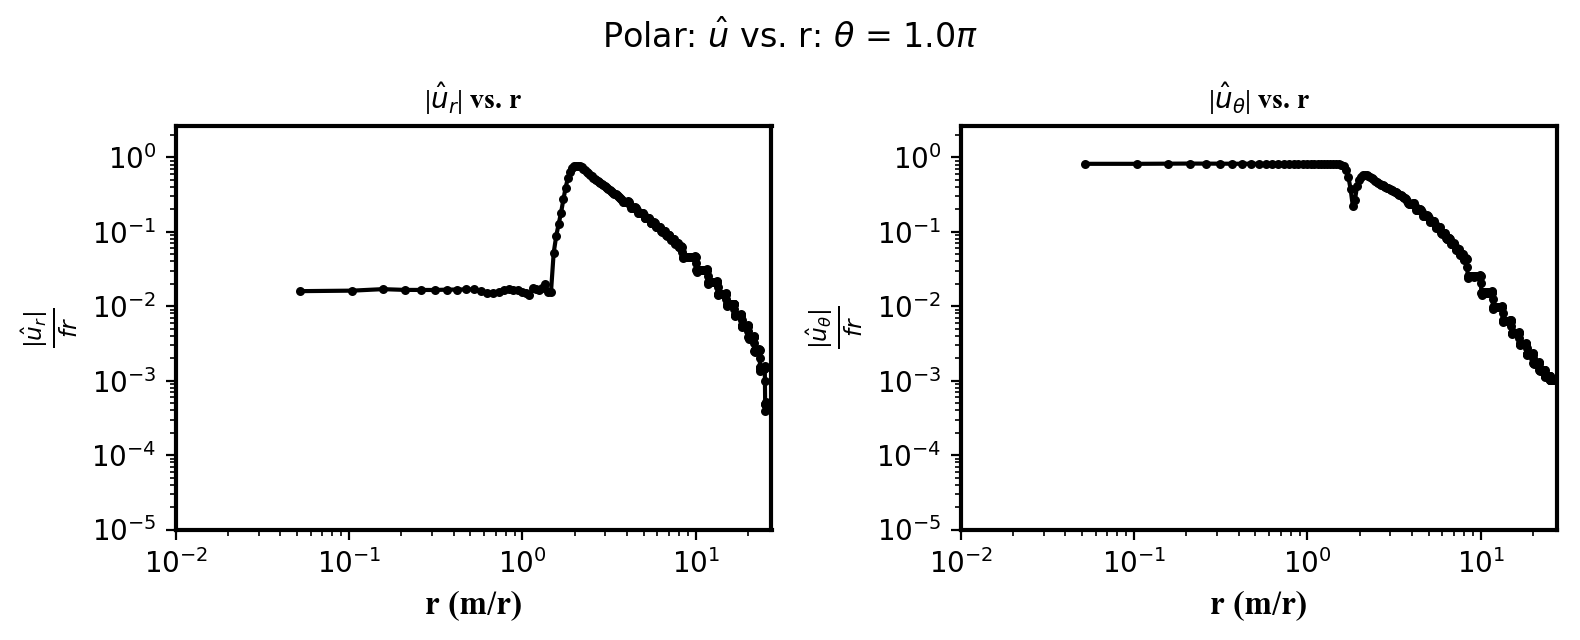

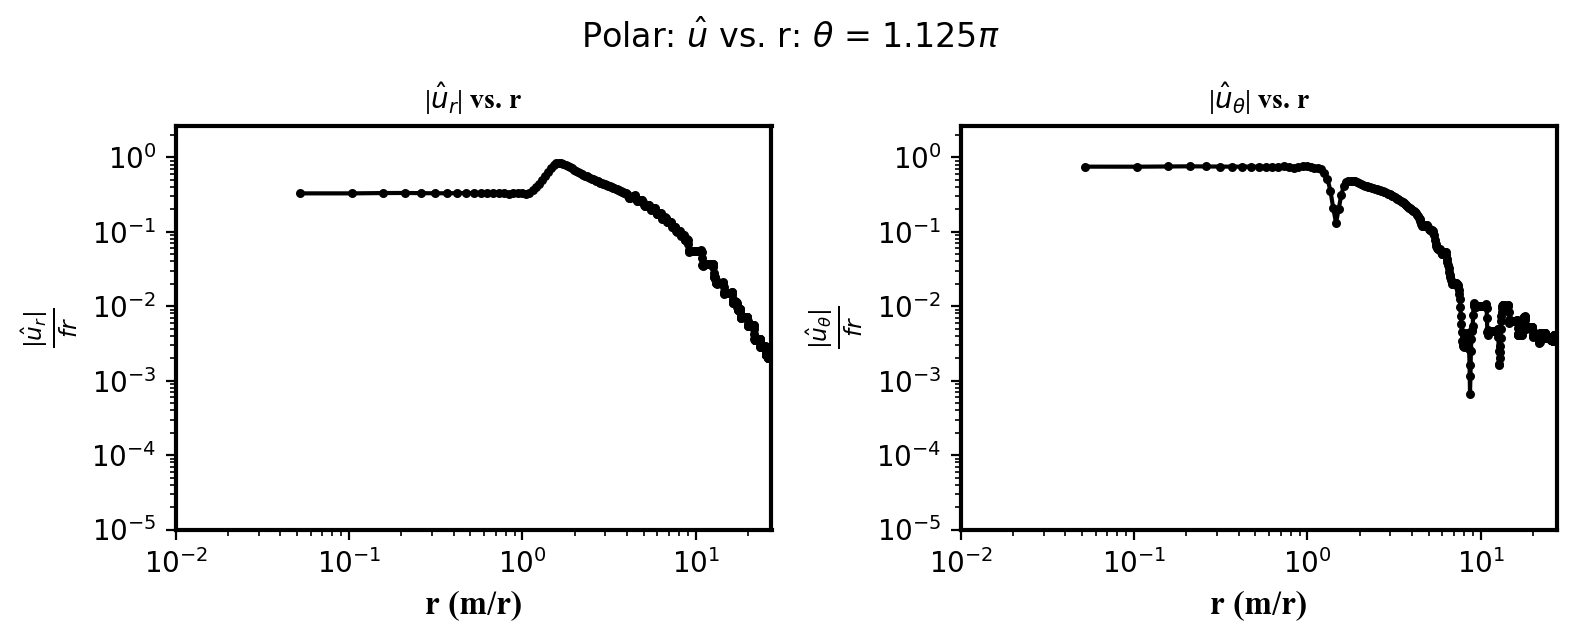

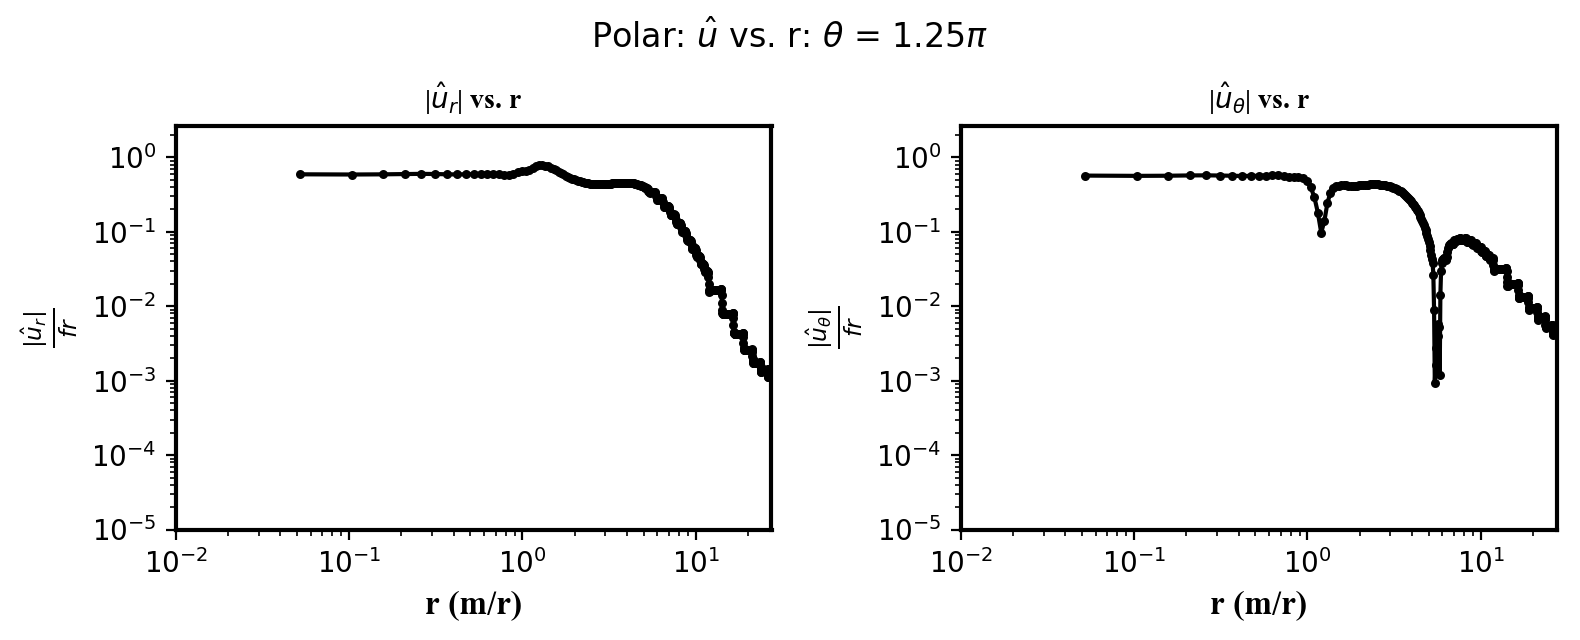

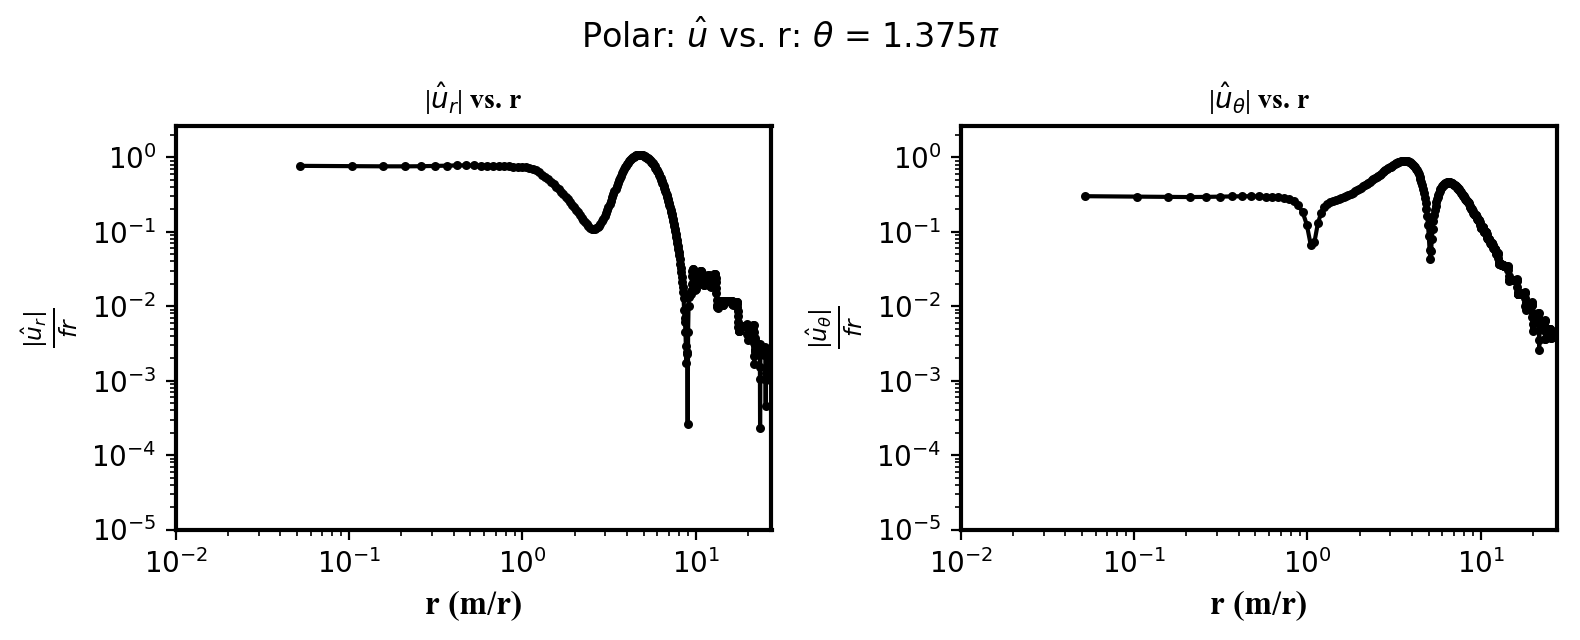

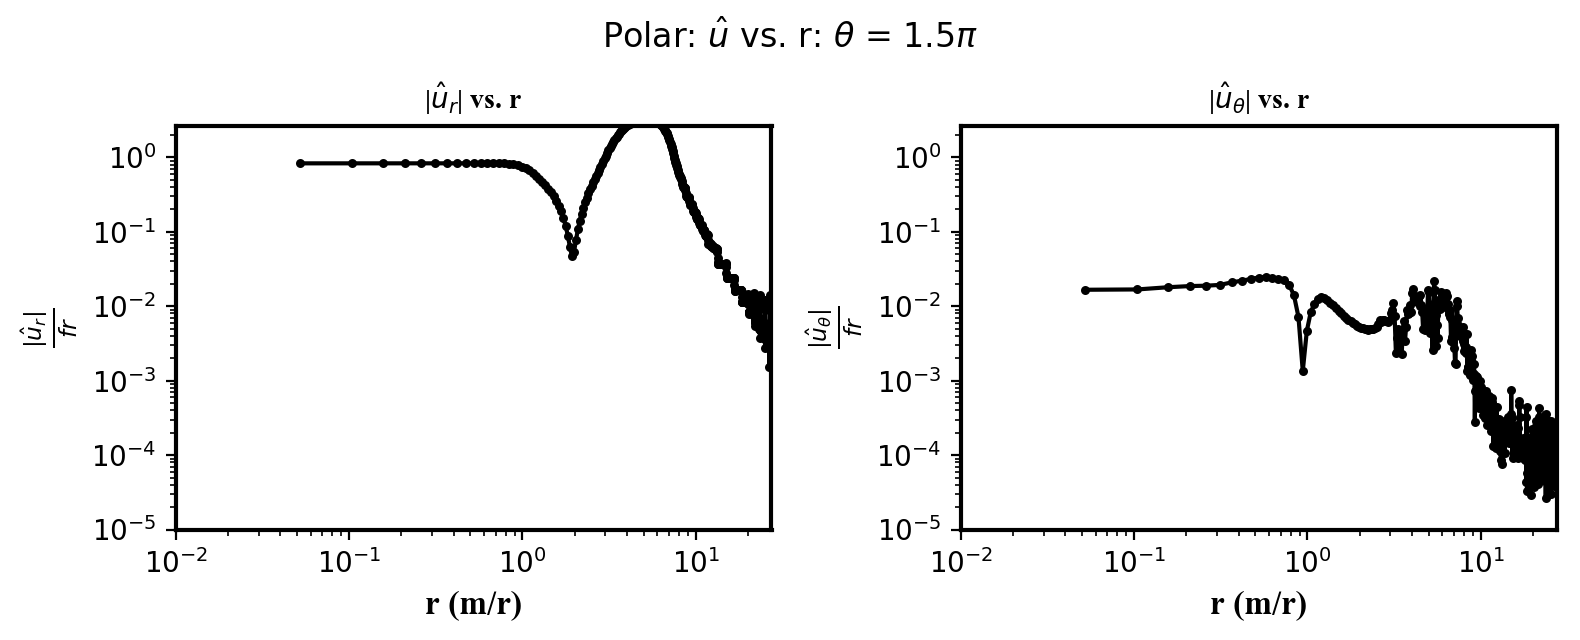

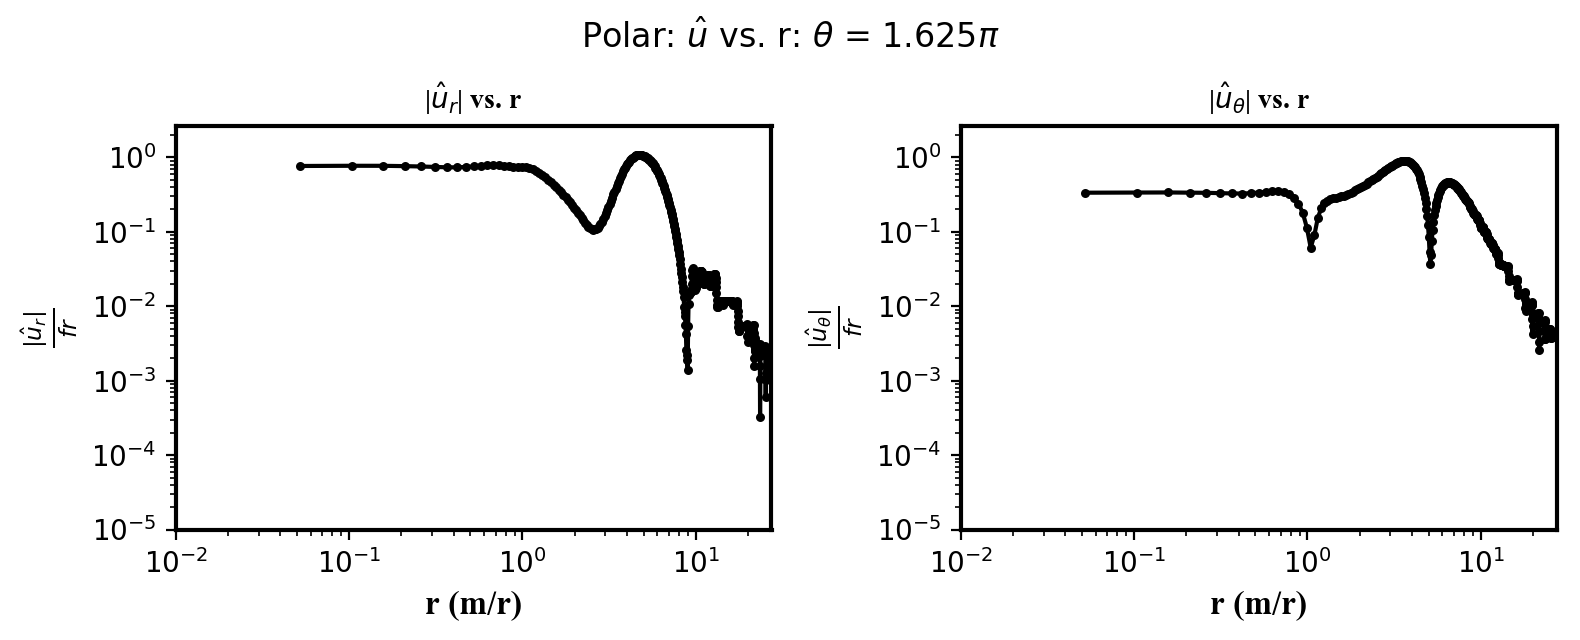

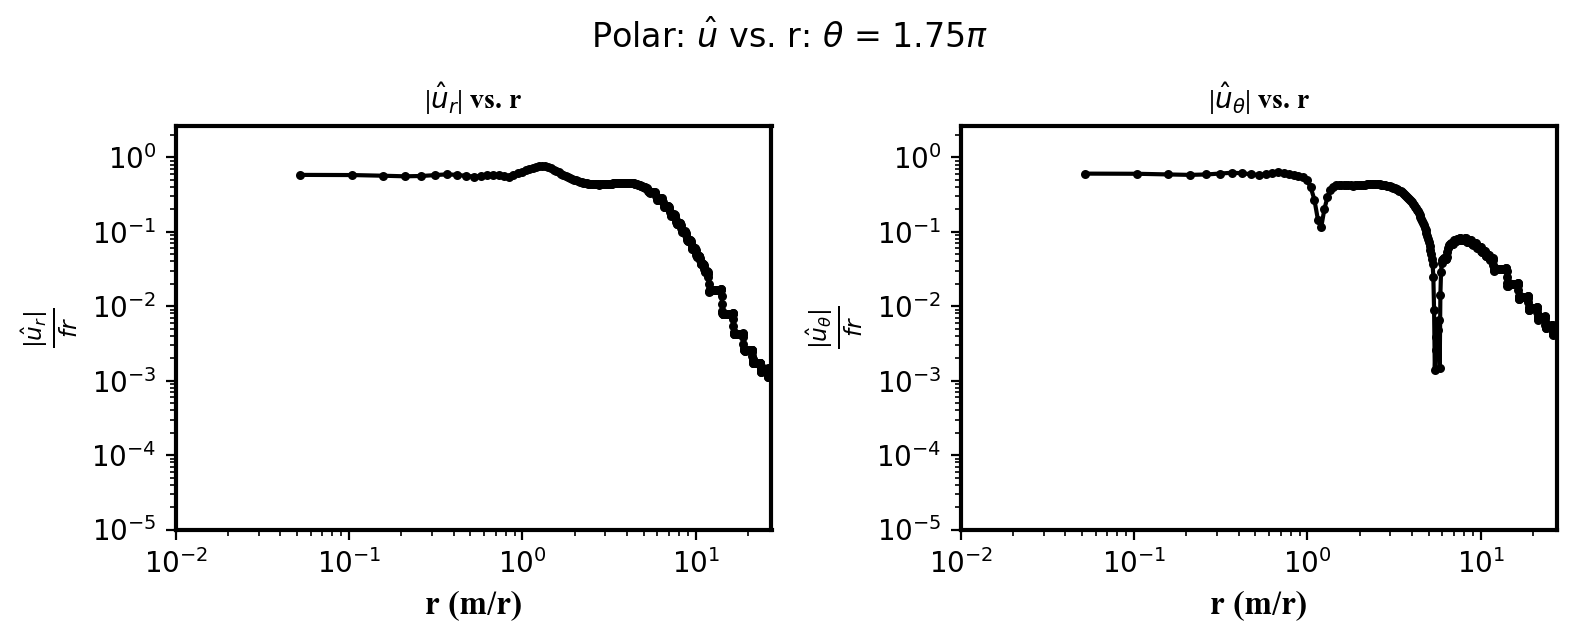

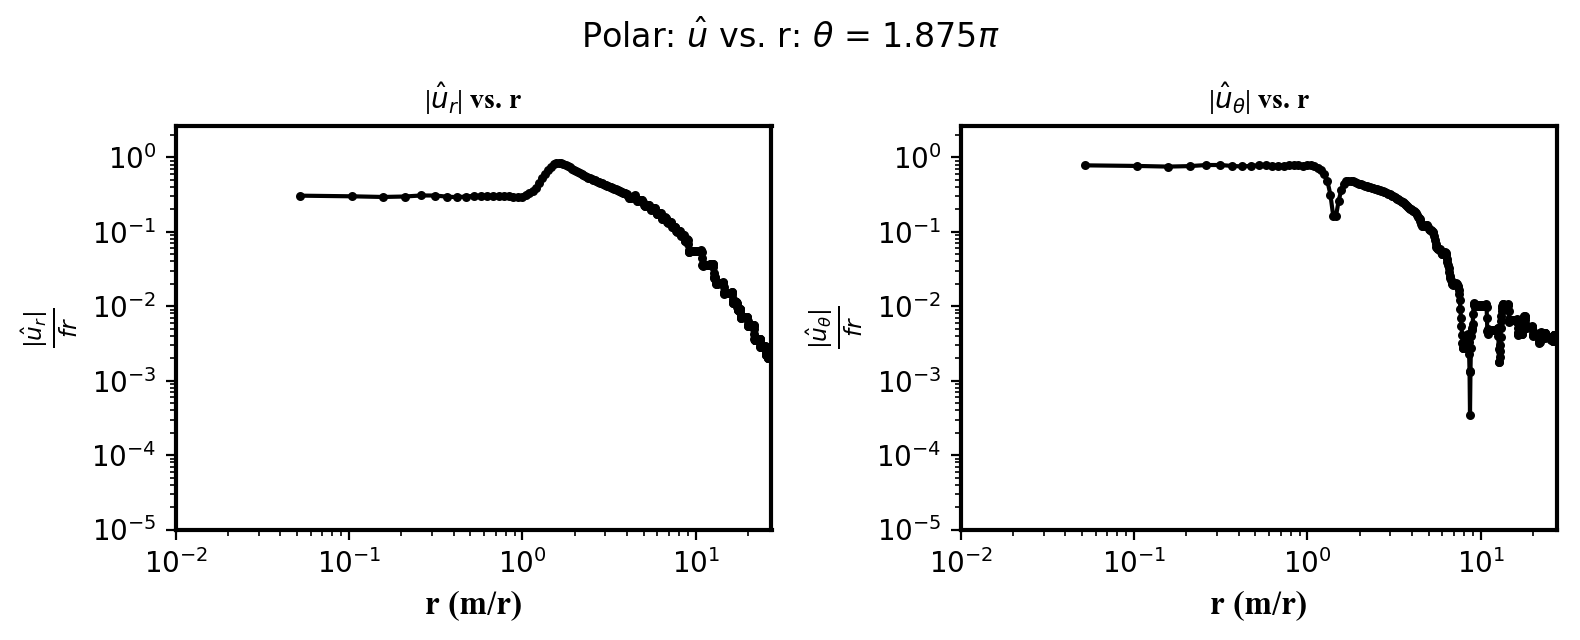

In [8]:
#Plot coefficients vs rval for both specified mesh coordinate
def Plot_hatU_vs_r(data,title):
    #Here, we will visualize the velocity field on the new coordinate system
    fig = plt.figure(figsize=(8,3),dpi=200)
    fig.suptitle(title,fontsize=12,y=1.05)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    #We will specify the time in the x-label
    ax1.set_title(r'|$\hat{u}_r$| vs. r',fontsize=10,**csfont)
    ax2.set_title(r'|$\hat{u}_{\theta}$| vs. r',fontsize=10,**csfont)
    ax1.set_ylabel(r'$\frac{|\hat{u}_r|}{fr}$',fontsize=12,**csfont)
    ax2.set_ylabel(r'$\frac{|\hat{u}_{\theta}|}{fr}$',fontsize=12,**csfont)
    val1 = data['hatUr'].copy()*PERIOD/RSMALL
    val2 = data['hatUt'].copy()*PERIOD/RSMALL
    ax1.set_xlabel('r (m/r)',fontsize=12,**csfont)
    ax2.set_xlabel('r (m/r)',fontsize=12,**csfont)
    xval = data['mr'].copy()
    
    #Now that we have the figure all labeled, let's add the force field
    #val1
    ax1.scatter(xval,val1,s=5,c='k')
    ax1.plot(xval,val1,c='k')
    #val2
    ax2.scatter(xval,val2,s=5,c='k')
    ax2.plot(xval,val2,c='k')
    
    ax1.set_xlim(0.01,4.1/RSMALL)
    ax2.set_xlim(0.01,4.1/RSMALL)
    ax1.set_ylim(1.0e-5,4.0*PERIOD/RSMALL)
    ax2.set_ylim(1.0e-5,4.0*PERIOD/RSMALL)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    fig.tight_layout()
    plt.show()
    fig.clf()
    plt.close()
    return

#Make a DataFrame of hatU components and mr,mt mesh
dTheta = 2.0*np.pi/(1.0*m)
#Create Database containing (instUt,instUr,mt,mr)
#Before that is done, we need to convert mx_new and my_new to mr and mt centered around CM
mr_new = np.hypot(newMesh[0,0],newMesh[0,1])
mt_new = np.zeros((m,m))
for idx in range(m):
    for jdx in range(m):
        mt_new[idx,jdx] = np.arctan(newMesh[0,1,idx,jdx]/newMesh[0,0,idx,jdx])
        if(newMesh[0,0,idx,jdx] < 0.0):
            #Shift angle by pi
            mt_new[idx,jdx] += np.pi 
        if(mt_new[idx,jdx] < 0.0):
            mt_new[idx,jdx] += 2.0*np.pi

dicthatU = {'mr':mr_new.flatten(),'mt':mt_new.flatten(),'hatUr':hatUmag[0].flatten(),'hatUt':hatUmag[1].flatten()}
data = pd.DataFrame(data=dicthatU)
data = data[data['mr'] > 0.0]
data = data.sort_values(by=['mt','mr'])
data = data.reset_index(drop=True)

#Determine # of distinct theta values
mt_list = data['mt'].tolist()
mt_list = [round(num,6) for num in mt_list]
set_t = set(mt_list)
print('num mt_list = ',len(mt_list))
print('num set_t = ',len(set_t))
tval_list = list(set_t)
tval_list = sorted(tval_list)
tval_list = [num/np.pi for num in tval_list]

#Plot hatU components vs. r
#For the thetas in the loop
for idx in range(0,len(set_t),32):
    tval = tval_list[idx]
    tempData = data[data['mt'].round(6) == round(tval*np.pi,6)]
    tempData = tempData.sort_values(by=['mr'])
    tempData.reset_index(drop=True)
    #Plot Ur, Ut, magU_polar vs r
    Plot_hatU_vs_r(tempData,r'Polar: $\hat{u}$ vs. r: $\theta$ = '+str(round(tval,4))+'$\pi$')